In [2]:
# Import Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import yaml
import math
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# For reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [3]:
# Helper Functions
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False):
    """Convolution 1x1 layer."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)

In [4]:
# Basic Block Implementation
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=0.4):
        """
        Convolutional Layer kernel size Fi
        Skip connection (shortcut) kernel size Ki
        """
        super(BasicBlock, self).__init__()
        self.drop = drop
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size,
                              stride=stride, padding=int(conv_kernel_size/2), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size,
                              stride=1, padding=int(conv_kernel_size/2), bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=shortcut_kernel_size,
                         stride=stride, padding=int(shortcut_kernel_size/2), bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        if self.drop:
            self.dropout = nn.Dropout(self.drop)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        if self.drop:
            out = self.dropout(out)
        return out

In [5]:
from collections import defaultdict
# Lookahead Optimizer Implementation
class Lookahead(torch.optim.Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        """
        Lookahead Optimizer: k steps forward, 1 step back

        Args:
            optimizer: wrapped optimizer
            k: number of lookahead steps (default: 5)
            alpha: linear interpolation factor (default: 0.5)
        """
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        self.defaults = optimizer.defaults
        for group in self.param_groups:
            group["counter"] = 0

    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)

    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

In [6]:
# SE Block Implementation
class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        mid_cannels = channels // reduction

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(channels, mid_cannels, bias=True)
        self.activ = nn.ReLU(inplace=True)
        self.conv2 = conv1x1(mid_cannels, channels, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x

In [7]:
# Modified ResNet Implementation
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, conv_kernel_sizes=None, shortcut_kernel_sizes=None,
                 num_classes=10, num_channels=32, avg_pool_kernel_size=4, drop=None,
                 squeeze_and_excitation=None):
        super(ResNet, self).__init__()
        self.in_planes = num_channels
        self.avg_pool_kernel_size = int(32 / (2**(len(num_blocks)-1)))

        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels)

        self.drop = drop
        self.squeeze_and_excitation = squeeze_and_excitation

        if self.squeeze_and_excitation:
            self.seblock = SEBlock(channels=self.num_channels)

        self.residual_layers = []
        for n in range(len(num_blocks)):
            stride = 1 if n==0 else 2
            conv_kernel_size = conv_kernel_sizes[n] if conv_kernel_sizes else 3
            shortcut_kernel_size = shortcut_kernel_sizes[n] if shortcut_kernel_sizes else 1
            self.residual_layers.append(
                self._make_layer(block, self.num_channels*(2**n), num_blocks[n],
                               stride=stride, conv_kernel_size=conv_kernel_size,
                               shortcut_kernel_size=shortcut_kernel_size)
            )

        self.residual_layers = nn.ModuleList(self.residual_layers)
        self.linear = nn.Linear(self.num_channels*(2**n)*block.expansion, num_classes)

        if self.drop:
            self.dropout = nn.Dropout(self.drop)

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size,
                    shortcut_kernel_size):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(
                block(self.in_planes, planes, stride, conv_kernel_size,
                      shortcut_kernel_size, drop=self.drop)
            )
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.squeeze_and_excitation:
            out = self.seblock(out)
        for layer in self.residual_layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        if self.drop:
            out = self.dropout(out)
        out = self.linear(out)
        return out

In [8]:
# Configuration
config = {
    # Model parameters
    "num_blocks": [4, 4, 3],
    "conv_kernel_sizes": [3, 3, 3],
    "shortcut_kernel_sizes": [1, 1, 1],
    "num_channels": 64,
    "avg_pool_kernel_size": 8,
    "drop": 0,
    "squeeze_and_excitation": False,

    # Training parameters
    "batch_size": 128,
    "num_workers": 8,
    "lr": 0.1,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "max_epochs": 300,
    "optim": "sgd",
    "lr_sched": "CosineAnnealingLR",
    "data_augmentation": True,
    "data_normalize": True,
    "grad_clip": None,

    # Lookahead parameters
    "use_lookahead": True,
    "lookahead_k": 5,      # number of lookahead steps
    "lookahead_alpha": 0.5  # linear interpolation factor
}

In [9]:
# Data Loading and Preprocessing
def get_data_loaders(config):
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(32, padding=4) if config["data_augmentation"] else transforms.Lambda(lambda x: x),
        transforms.RandomHorizontalFlip() if config["data_augmentation"] else transforms.Lambda(lambda x: x),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) if config["data_normalize"] else transforms.Lambda(lambda x: x)
    ])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) if config["data_normalize"] else transforms.Lambda(lambda x: x)
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=config["batch_size"], shuffle=True,
        num_workers=config["num_workers"])

    valset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_val)
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=config["batch_size"]//4, shuffle=False,
        num_workers=config["num_workers"])

    return trainloader, valloader

trainloader, valloader = get_data_loaders(config)

57.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


In [10]:
# Training and Validation Functions
def train(epoch, net, device, trainloader, optimizer, criterion, config):
    print(f'\nEpoch: {epoch}')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_losses = []
    train_acc = []

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        if config["grad_clip"]:
            nn.utils.clip_grad_value_(net.parameters(), clip_value=config["grad_clip"])

        optimizer.step()

        train_loss += loss.item()
        train_losses.append(train_loss)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        train_acc.append(100.*correct/total)

        if batch_idx % 100 == 0:
            print(f'Batch: {batch_idx} | Loss: {train_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.*correct/total:.3f}% ({correct}/{total})')

    return np.mean(train_losses), np.mean(train_acc)

def val(epoch, net, device, valloader, criterion):
    net.eval()
    val_loss = 0
    val_losses = []
    val_acc = []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_losses.append(val_loss)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            val_acc.append(100.*correct/total)

    acc = 100.*correct/total
    print(f'Validation Acc: {acc:.3f}%')
    return np.mean(val_losses), np.mean(val_acc), acc

In [11]:
# Model Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Initialize model
net = ResNet(
    block=BasicBlock,
    num_blocks=config["num_blocks"],
    conv_kernel_sizes=config["conv_kernel_sizes"],
    shortcut_kernel_sizes=config["shortcut_kernel_sizes"],
    num_channels=config["num_channels"],
    avg_pool_kernel_size=config["avg_pool_kernel_size"],
    drop=config["drop"],
    squeeze_and_excitation=config["squeeze_and_excitation"]
)
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.SGD(net.parameters(), lr=config["lr"],
                          momentum=config["momentum"],
                          weight_decay=config["weight_decay"])

# Wrap the optimizer with Lookahead
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # k steps forward, 1 step back
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

Using device: cuda


In [12]:
# Training Loop
writer = SummaryWriter('summaries/notebook_run')
best_acc = 0

# Store metrics for visualization
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(config["max_epochs"]):
    # Train
    train_loss, train_acc = train(epoch, net, device, trainloader, optimizer, criterion, config)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)

    # Validation
    val_loss, val_acc, current_acc = val(epoch, net, device, valloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    # Save checkpoint if the accuracy improves
    if current_acc > best_acc:
        print('Saving checkpoint...')
        state = {
            'net': net.state_dict(),
            'acc': current_acc,
            'epoch': epoch,
            'config': config
        }
        if not os.path.exists('checkpoints'):
            os.makedirs('checkpoints')
        torch.save(state, './checkpoints/best_model.pth')
        best_acc = current_acc

    scheduler.step()

writer.close()
print(f'Best accuracy: {best_acc}%')



Epoch: 0
Batch: 0 | Loss: 2.460 | Acc: 10.156% (13/128)
Batch: 100 | Loss: 2.179 | Acc: 22.293% (2882/12928)
Batch: 200 | Loss: 1.961 | Acc: 27.732% (7135/25728)
Batch: 300 | Loss: 1.840 | Acc: 31.870% (12279/38528)
Validation Acc: 47.910%
Saving checkpoint...

Epoch: 1
Batch: 0 | Loss: 1.423 | Acc: 49.219% (63/128)
Batch: 100 | Loss: 1.371 | Acc: 49.010% (6336/12928)
Batch: 200 | Loss: 1.315 | Acc: 51.531% (13258/25728)
Batch: 300 | Loss: 1.265 | Acc: 53.468% (20600/38528)
Validation Acc: 56.740%
Saving checkpoint...

Epoch: 2
Batch: 0 | Loss: 0.968 | Acc: 62.500% (80/128)
Batch: 100 | Loss: 1.035 | Acc: 62.276% (8051/12928)
Batch: 200 | Loss: 1.005 | Acc: 63.720% (16394/25728)
Batch: 300 | Loss: 0.983 | Acc: 64.672% (24917/38528)
Validation Acc: 63.280%
Saving checkpoint...

Epoch: 3
Batch: 0 | Loss: 0.885 | Acc: 71.094% (91/128)
Batch: 100 | Loss: 0.831 | Acc: 70.800% (9153/12928)
Batch: 200 | Loss: 0.815 | Acc: 71.424% (18376/25728)
Batch: 300 | Loss: 0.792 | Acc: 72.197% (27816/3

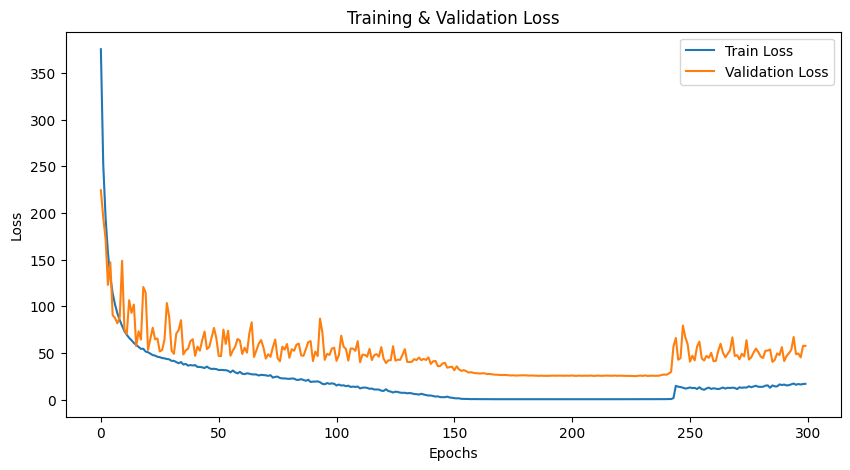

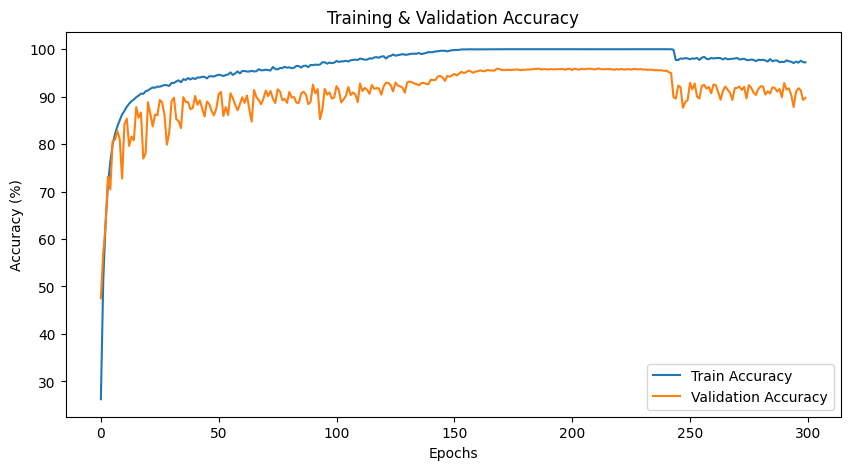

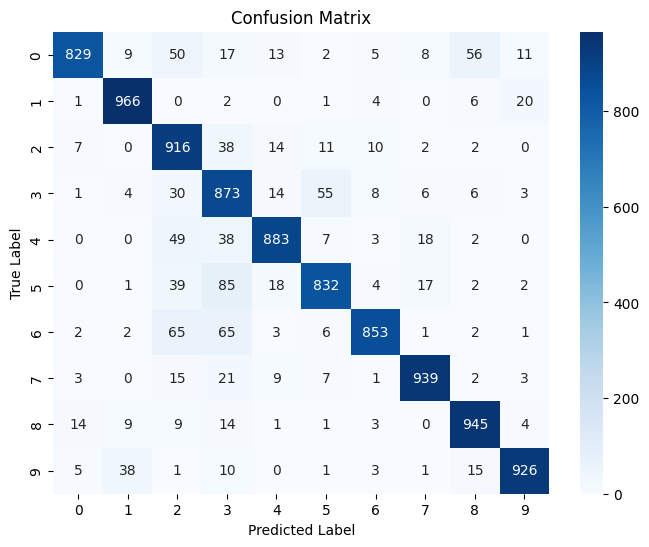

Classification Report:
               precision    recall  f1-score   support

           0     0.9617    0.8290    0.8904      1000
           1     0.9388    0.9660    0.9522      1000
           2     0.7802    0.9160    0.8427      1000
           3     0.7506    0.8730    0.8072      1000
           4     0.9246    0.8830    0.9033      1000
           5     0.9014    0.8320    0.8653      1000
           6     0.9541    0.8530    0.9007      1000
           7     0.9466    0.9390    0.9428      1000
           8     0.9104    0.9450    0.9274      1000
           9     0.9546    0.9260    0.9401      1000

    accuracy                         0.8962     10000
   macro avg     0.9023    0.8962    0.8972     10000
weighted avg     0.9023    0.8962    0.8972     10000



In [13]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# Confusion matrix
all_preds = []
all_labels = []
net.eval()
with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=range(10), columns=range(10))
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)

In [14]:
# Custom Dataset Evaluation
import pickle
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

class CustomTestDataset(Dataset):
    def __init__(self, pkl_file, transform=None):
        """
        Args:
            pkl_file (string): Path to the pkl file with structure:
            {
                b'data': numpy array of shape (N, 32, 32, 3),
                b'ids': numpy array of shape (N,)
            }
        """
        with open(pkl_file, 'rb') as f:
            self.data = pickle.load(f)

        # Extract data and ids from the dictionary
        self.images = self.data[b'data']  # Shape: (10000, 32, 32, 3)
        self.ids = self.data[b'ids']      # Shape: (10000,)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and ID
        image = self.images[idx]  # Shape: (32, 32, 3)
        image_id = self.ids[idx]

        # Convert numpy array to PIL Image for transforms
        image = image.astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, image_id

# Define transforms for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load custom test dataset
custom_testset = CustomTestDataset(
    pkl_file='cifar_test_nolabel.pkl',
    transform=transform_test
)

# Create dataloader
custom_testloader = DataLoader(
    custom_testset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

# Make predictions
predictions = []
ids = []

net.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch_images, batch_ids in custom_testloader:
        batch_images = batch_images.to(device)
        outputs = net(batch_images)
        _, predicted = outputs.max(1)

        # Convert predictions to CPU and numpy
        batch_predictions = predicted.cpu().numpy()

        predictions.extend(batch_predictions)
        ids.extend(batch_ids.numpy())

# Create DataFrame and save to CSV
results_df = pd.DataFrame({
    'ID': ids,
    'Labels': predictions
})

# Save to CSV
results_df.to_csv('predictions.csv', index=False)

print(f"Predictions saved to predictions.csv")
print(f"Total predictions made: {len(predictions)}")
print("\nFirst few predictions:")
print(results_df.head())

# Optional: Print value counts of predictions
print("\nDistribution of predicted labels:")
print(results_df['Labels'].value_counts())

Predictions saved to predictions.csv
Total predictions made: 10000

First few predictions:
   ID  Labels
0   0       6
1   1       1
2   2       8
3   3       6
4   4       9

Distribution of predicted labels:
Labels
3    1325
2    1255
8    1115
1    1062
7    1038
9    1002
5     938
6     833
4     822
0     610
Name: count, dtype: int64


In [15]:
# Count Model Parameters for verification
def count_parameters(model):
    """
    Count the total number of trainable parameters in the model
    """
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Parameter details for each layer
    print("Parameter details for each layer:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel():,} parameters")

    print("\nSummary:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Calculate model size in MB
    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    print(f"Model Size: {model_size:.2f} MB")

    return total_params, trainable_params

# Count parameters for the loaded checkpoint model
if 'net' in locals():
    print("Counting parameters for the loaded checkpoint model:")
    total, trainable = count_parameters(net)
else:
    print("Model not found in memory. Loading checkpoint first...")
    checkpoint = torch.load('/content/best_model.pth', map_location=torch.device('cpu'))
    net = ResNet(
        block=BasicBlock,
        num_blocks=checkpoint['config']["num_blocks"],
        conv_kernel_sizes=checkpoint['config']["conv_kernel_sizes"],
        shortcut_kernel_sizes=checkpoint['config']["shortcut_kernel_sizes"],
        num_channels=checkpoint['config']["num_channels"],
        avg_pool_kernel_size=checkpoint['config']["avg_pool_kernel_size"],
        drop=checkpoint['config']["drop"],
        squeeze_and_excitation=checkpoint['config'].get("squeeze_and_excitation", False)
    )
    net.load_state_dict(checkpoint['net'])
    total, trainable = count_parameters(net)

# Verify against 5M parameter limit
if total > 5_000_000:
    print("\nWARNING: Model exceeds 5M parameter limit!")
    print(f"Excess parameters: {total - 5_000_000:,}")
else:
    print(f"\nModel is within 5M parameter limit")
    print(f"Remaining parameter budget: {5_000_000 - total:,}")

Counting parameters for the loaded checkpoint model:
Parameter details for each layer:
module.conv1.weight: 1,728 parameters
module.bn1.weight: 64 parameters
module.bn1.bias: 64 parameters
module.residual_layers.0.0.conv1.weight: 36,864 parameters
module.residual_layers.0.0.bn1.weight: 64 parameters
module.residual_layers.0.0.bn1.bias: 64 parameters
module.residual_layers.0.0.conv2.weight: 36,864 parameters
module.residual_layers.0.0.bn2.weight: 64 parameters
module.residual_layers.0.0.bn2.bias: 64 parameters
module.residual_layers.0.1.conv1.weight: 36,864 parameters
module.residual_layers.0.1.bn1.weight: 64 parameters
module.residual_layers.0.1.bn1.bias: 64 parameters
module.residual_layers.0.1.conv2.weight: 36,864 parameters
module.residual_layers.0.1.bn2.weight: 64 parameters
module.residual_layers.0.1.bn2.bias: 64 parameters
module.residual_layers.0.2.conv1.weight: 36,864 parameters
module.residual_layers.0.2.bn1.weight: 64 parameters
module.residual_layers.0.2.bn1.bias: 64 paramet